In [1]:
# Import libraries

# Script libraries
import affine
import numpy as np
import rasterio as rio

import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

# Additional libraries
%matplotlib inline
import matplotlib.pyplot as plt

# Tutorial: Clip raster into quadrants

## Purpose: prepare data for in-memory processing

### Practical use: when images has too big resolution for in-memory processing and RAM capacity in the processing computer is too low then it is possible to cut image into parts which are fitted into the processing computer's RAM

* More about this technique: https://...

#### A. DATA

> Landsat 8 scene (LC08_L1TP_190022_20130415_20170505_01_T1_sr_band5.tif), band 5 (Near-infrared)

In [2]:
datafile = 'data/LC08_L1TP_190022_20130415_20170505_01_T1_sr_band5.tif'
with rio.open(datafile, 'r') as src:
    band = src.read(1)
    c = 2**16
    band = band * 1/c
    band = band / np.max(band)
    band[band <= 0] = np.nan

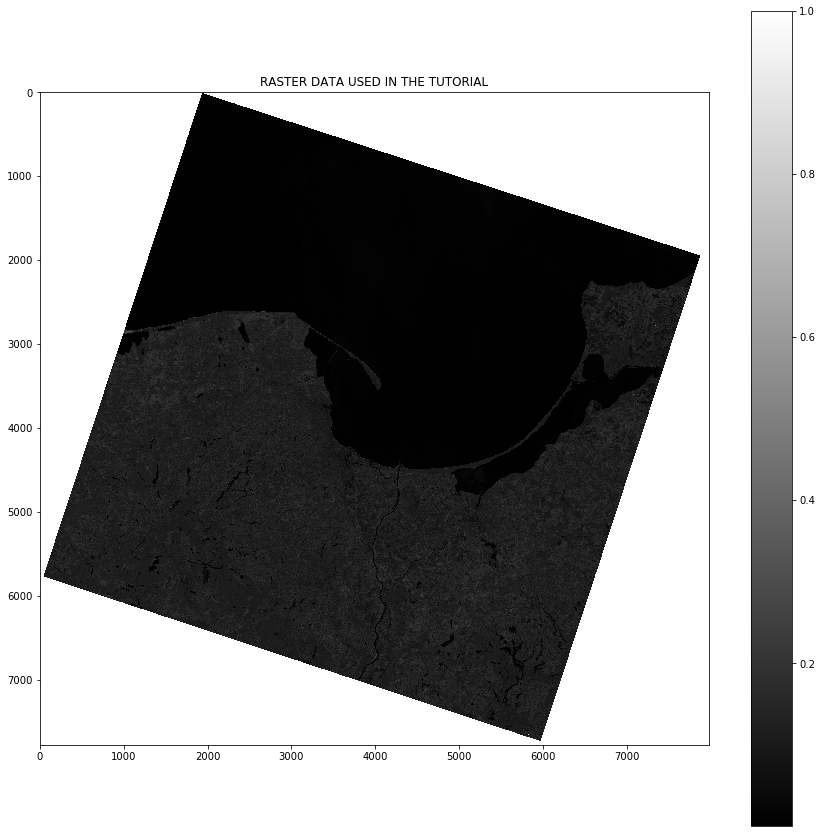

In [3]:
plt.figure(figsize=(15, 15))
plt.imshow(band, cmap='gray')
plt.title('RASTER DATA USED IN THE TUTORIAL')
plt.colorbar()
plt.show()

#### B. Script

> Script address: https://github.com/szymon-datalions/geoprocessing/blob/master/rasters/clip_into_quadrants.py

In [4]:
class ImageForClipModel:
    """Class for clipping big raster images into smaller parts. Class initialized with image address.
    Class has only one method with two modes of work:
    
    1 - clipped data is saved,
    2 - clipped data is stored in the list clipped_images.
    
    Default mode is (2). It is recommend to use it only during the development and debugging with small images.
    """

    # Get band, band shape, dtype, crs and transform values
    def __init__(self, image_address):
        with rio.open(image_address, 'r') as f:
            self.band = f.read(1)
            self.crs = f.crs
            self.base_transform = f.transform
        self.band_shape = self.band.shape
        self.band_dtype = self.band.dtype
        self.clipped_images = []
        self.clipped_addresses = []

    # Function for clipping band
    def clip_raster(self, height, width, buffer=0, save_mode=False, prefix='clipped_band_', pass_empty=False):
        """
        Function clips and stores / saves raster data
        
        INPUT:
        :param height: height of the clipped image in pixels.
            If (height of the raster) % (height of clipped image) != 0 then one slice of the clipped tiles
            will have height = (height of the raster) % (height of clipped image),
        :param width: width of the clipped image in pixels,
            If (width of the raster) % (width of clipped image) != 0 then one slice of the clipped tiles
            will have width = (width of the raster) % (width of clipped image),
        :param buffer: default = 0. 
        If buffer is provided then clipped tiles overlaps by number of pixels provided in this
            variable. As example: if width = 1000 and buffer is 10 then the first tile will be extracted from
            columns 1 to 1000, the second tile from 991 to 1990. The formula is:
            where i > 1
            then start_column = 1000 * (i - 1) - (buffer * (i - 1)) + 1
            end_column = start_column + 999
        :param save_mode: default = False.
        If save_mode is true then clipped tiles will be stored as the new raster images, else clipped tiles
            are stored in the class attribute clipped_images (list),
        :param prefix: default = 'clipped_band_'.
        Prefix of the clipped data if it is saved as the static files.
        :param pass_empty: default = False.
        Method checks clipped data with np.mean function to prevent saving images which contain only zeros (usually
        no data values). Optional.
        
        OUTPUT
        :return clipped_addresses: if save_mode is True (list of strings with the clipped tiles paths)
        or
        :return clipped_images: if save_mode is False (list of clipped bands as numpy arrays).
        """
        row_position = 0
        while row_position < self.band_shape[0]:
            col_position = 0
            while col_position < self.band_shape[1]:
                clipped_image = self.band[row_position:row_position + height,
                                col_position:col_position + width]

                # Check if frame is empty
                if pass_empty:
                    if np.mean(clipped_image) == 0:
                        print('Empty frame, not saved')
                        break

                # Positioning
                tcol, trow = self.base_transform * (col_position, row_position)
                new_transform = affine.Affine(self.base_transform[0], self.base_transform[1], tcol,
                                              self.base_transform[3], self.base_transform[4], trow)
                image = [clipped_image, self.crs, new_transform,
                         clipped_image.shape[0], clipped_image.shape[1],
                         self.band_dtype]

                # Save or append into a set
                if save_mode:
                    filename = prefix + 'x_' + str(col_position) + '_y_' + str(row_position) + '.tif'
                    with rio.open(filename, 'w', driver='GTiff', height=image[3],
                                  width=image[4], count=1, dtype=image[5],
                                  crs=image[1], transform=image[2]) as dst:
                        dst.write(image[0], 1)
                    clipped_addresses.append(filename)
                else:
                    self.clipped_images.append(clipped_image)

                # Update column position
                col_position = col_position + width - buffer

            # Update row position
            row_position = row_position + height - buffer

        if save_mode:
            print('Tiles saved successfully')
            return self.clipped_addresses
        else:
            print('Tiles prepared successfully')
            return self.clipped_images

#### C. Processing steps

In [5]:
# Initialize pipeline

clipped_model = ImageForClipModel(datafile)

# Process data - save images in memory

band_parts = clipped_model.clip_raster(
    height=3000,
    width=3000,
    buffer=10,
    save_mode=False,
    prefix='clipped_band_',
    pass_empty=False,
)

Tiles prepared successfully


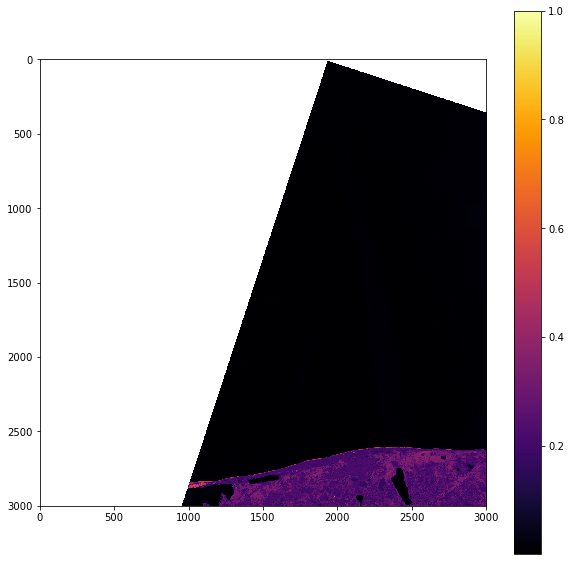

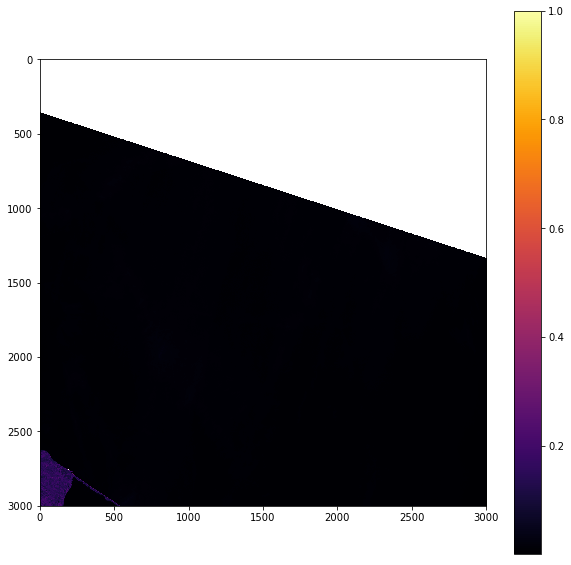

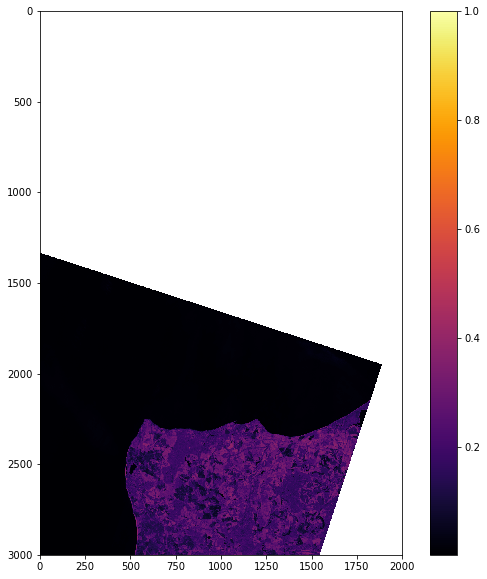

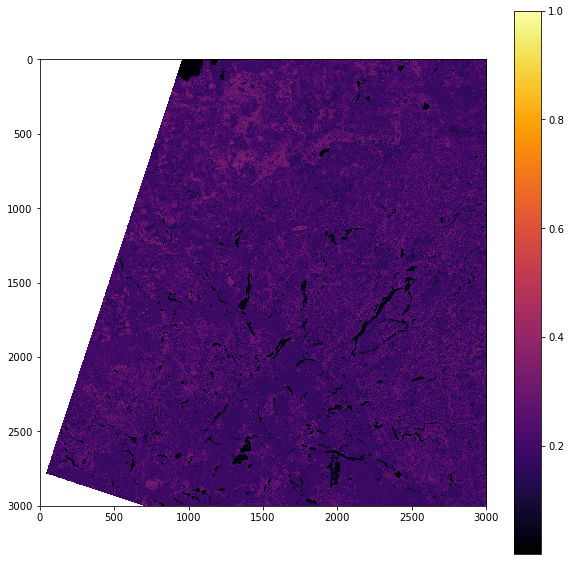

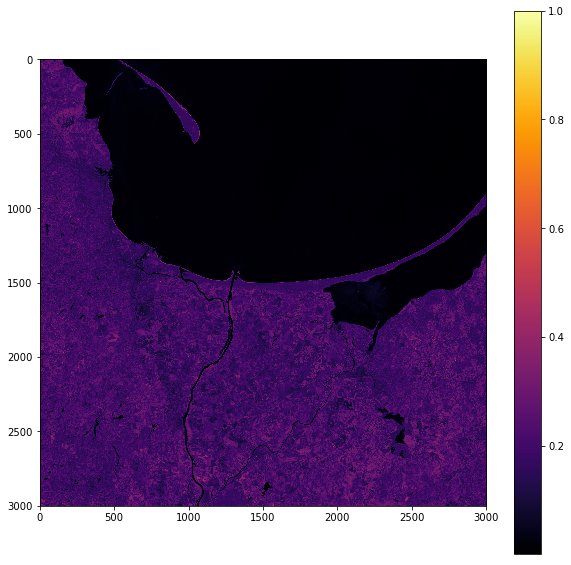

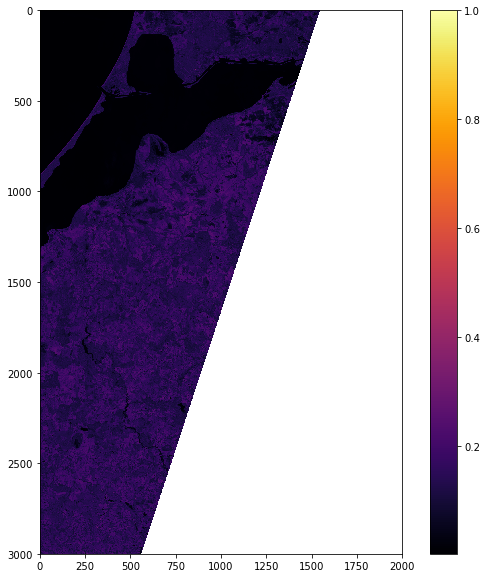

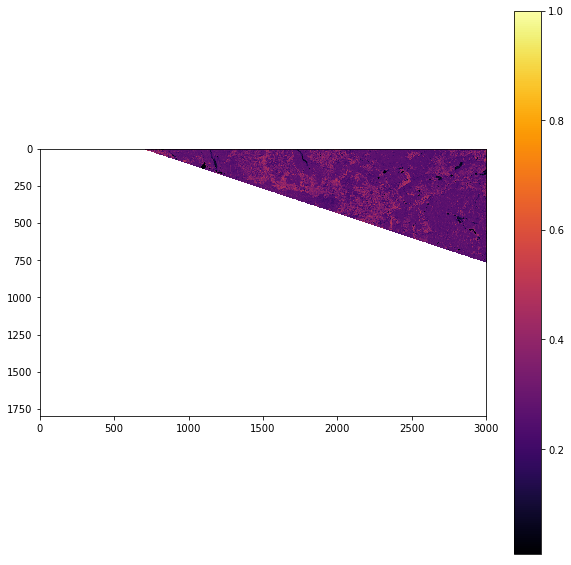

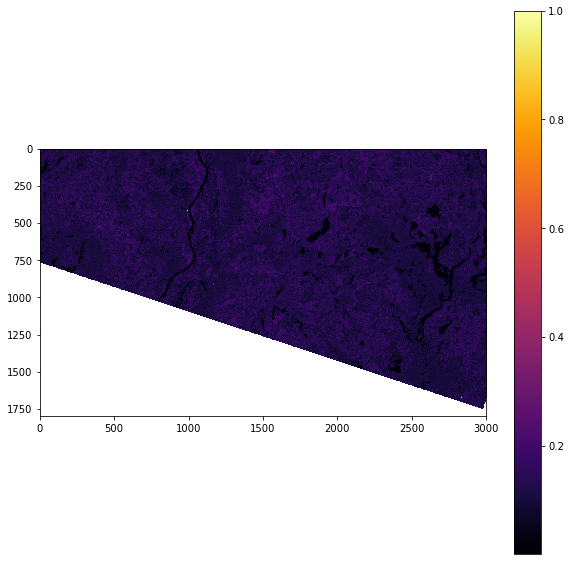

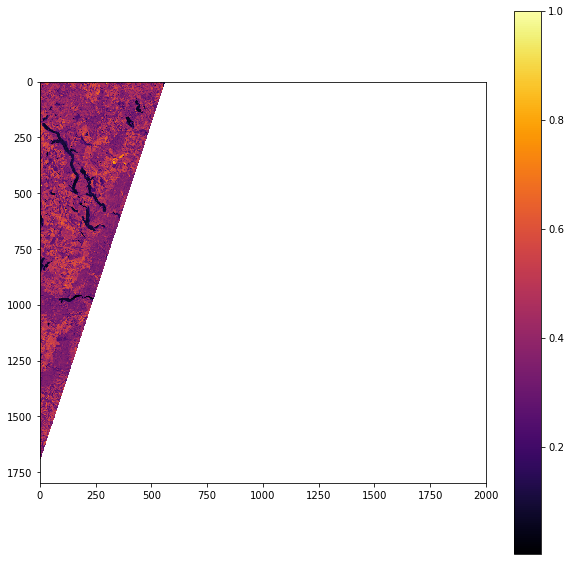

In [6]:
# Show results

for tile in band_parts:
    plt.figure(figsize=(10, 10))
    c = 2**16
    tile = tile * 1/c
    tile = tile / np.max(tile)
    tile[tile <= 0] = np.nan
    plt.imshow(tile, cmap='inferno')
    plt.colorbar()
    plt.show()